# Polynomial minimization

This examples shows how to solve a constrained polynomial minimization problem. Given p(x) and g(x), consider the problem in `x`

    min  p(x)
    s.t  g(x) >= 0
    
We can lower bound the optimal value by solving the following problem in `gamma, sigma(x)`

    max   gamma
    s.t.  p(x) - gamma - sigma(x) g(x) >= 0
          sigma(x) >= 0

In [1]:
from sympy.abc import x, y
from posipoly.polynomial import *

tot_deg = 8               # overall degree of problem
sigma_deg = tot_deg - 2   # degree of sigma

p = Polynomial.from_sympy(-x**2 - y**2 + x)
g = Polynomial.from_sympy(1 - x**2 - y**2)

Let `c_gamma, c_sigma` be monomial coefficients for `gamma(x), sigma(x)`, i.e. `sigma(x) = c_gamma' * M(x)` where `M(x)` is a vector of monomials.

Let `gamma(x)`, and let `S1, S2` be matrix representations of `pos1(x), pos2(x)`, i.e. `pos1(x) = M(x)' S1 M(x)`. Let the variable vector be `x = [c_gamma vec(sigma) vec(S1)]`. We can then write

    max   c' * x
    s.t.  [I_cc    T_cv   I_cv] * x = c_p
    
          mat(sigma) sdsos
          mat(S1)    sdsos
          
where `I_cc` is the coef -> coef identity transformation, `T_cv` is the vec -> coef "*p" transformation, and `I_cv` is the vec -> coef identity transformation.

In [2]:
from posipoly.polylintrans import *

A_gamma = PolyLinTrans.eye(1, 2, 0, tot_deg).as_Tcc()
A_sigma = PolyLinTrans.mul_pol(2, sigma_deg, g).as_Tcv()
A_S1 = PolyLinTrans.eye(2, 2, tot_deg).as_Tcv()

n_gamma = A_gamma.shape[1]
n_sigma = A_sigma.shape[1]
n_S1 = A_S1.shape[1]

Aeq = sp.bmat([[A_gamma, A_sigma, A_S1]])
beq = p.mon_coefs(tot_deg)

c = np.zeros(Aeq.shape[1])
c[0] = 1

In [3]:
import mosek
from posipoly.sdd import add_sdd_mosek

numcon, numvar = Aeq.shape

env = mosek.Env() 
task = env.Task(0,0)

# add variables and constraints
task.appendvars(numvar)
task.appendcons(numcon)

# make vars unbounded (fr: free)
task.putvarboundslice(0, numvar, [mosek.boundkey.fr] * numvar, [0.]*numvar, [0.]*numvar )

# objective
task.putcslice(0, numvar, c)
task.putobjsense(mosek.objsense.maximize)

# add eq constraints (fx: fixed)
task.putaijlist(Aeq.row, Aeq.col, Aeq.data)
task.putconboundslice(0, numcon, [mosek.boundkey.fx] * numcon, beq, beq )

# add sdsos contraints
add_sdd_mosek(task, n_gamma, n_sigma)      # make sigma sdsos
add_sdd_mosek(task, n_gamma+n_sigma, n_S1) # make S1 sdsos

task.optimize()

solsta = task.getsolsta(mosek.soltype.itr)

if (solsta == mosek.solsta.optimal):
    opt_gamma = [0.]
    task.getxxslice(mosek.soltype.itr, 0, 1, opt_gamma)
    
    print('a lower bound on the polynomial is {:.2f}'.format(opt_gamma[0]))
    
else:
    print('optimal solution not found')

a lower bound on the polynomial is -2.00


<IPython.core.display.Javascript object>


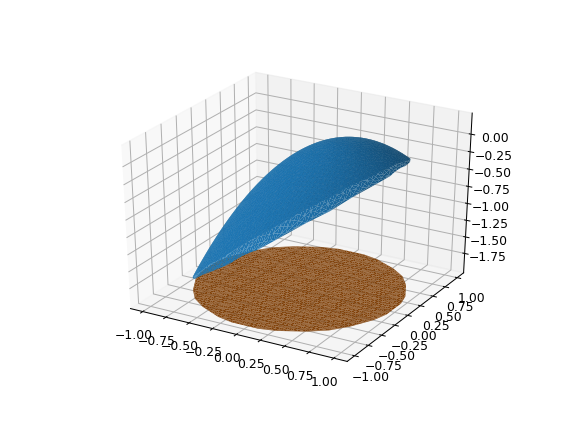

In [4]:
# plot polynomial for comparison
%matplotlib notebook
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

XX, YY = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
XX = XX.flatten()
YY = YY.flatten()

VV = np.vectorize(p.evaluate)(XX, YY)
VV_control = opt_gamma[0] * np.ones(VV.shape)

mask = np.vectorize(g.evaluate)(XX, YY) >= 0

ax = plt.figure().gca(projection='3d')
ax.plot_trisurf(XX[mask], YY[mask], VV[mask])
ax.plot_trisurf(XX[mask], YY[mask], VV_control[mask])

plt.show()